In [1]:
import torch
import torch.nn as nn
import torchvision as tv
from torch.utils.data import DataLoader

import numpy as np
import random
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import seaborn as sns


from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture as GMM


from typing import Tuple, List

%matplotlib inline

In [2]:
def get_mnist_ds(is_train:bool):
    return tv.datasets.MNIST(root = Path('mnistdata'),
                             train = is_train,
                             transform = tv.transforms.ToTensor(),
                             target_transform = None,
                             download = True
                            )

In [3]:
def get_mnist_ds_loader(batch_size):
        train_ds = get_mnist_ds(is_train = True)
        valid_ds = get_mnist_ds(is_train = False)
        
        return (DataLoader(train_ds, batch_size, shuffle = True),
                DataLoader(valid_ds, 2*batch_size, shuffle = False))
    

In [4]:
train_dl, valid_dl = get_mnist_ds_loader(32)

In [5]:
len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [6]:
train_dl.dataset.data.shape

torch.Size([60000, 28, 28])

torch.Size([32, 1, 28, 28])
torch.Size([32])


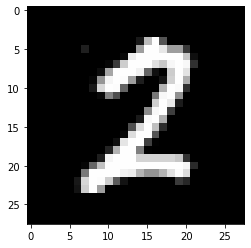

torch.Size([32, 1, 28, 28])
torch.Size([32])


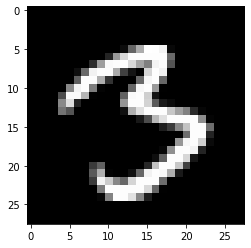

torch.Size([32, 1, 28, 28])
torch.Size([32])


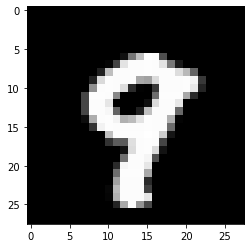

torch.Size([32, 1, 28, 28])
torch.Size([32])


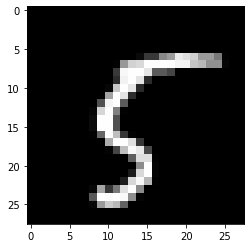

torch.Size([32, 1, 28, 28])
torch.Size([32])


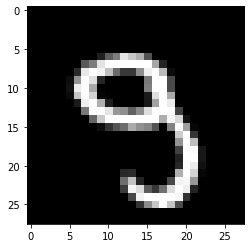

In [7]:
for i, x in enumerate(train_dl):
    print(x[0].shape)
    print(x[1].shape)
    plt.imshow(x[0][0][0],cmap='gray')
    plt.show()
    if i>3 : break

In [8]:
class Encoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        
        super().__init__()
        
        self.enc = nn.Sequential(nn.Flatten(),
                                 nn.Linear(np.prod(inp_size), hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_size))
        
    def forward(self, x):
        return self.enc(x)
        

In [9]:
class Decoder(nn.Module):
    def __init__(self, inp_size: int, hidden_size: int, out_size: Tuple[int,int]):
        
        super().__init__()
        self.out_size = out_size
        self.dec = nn.Sequential(nn.Linear(inp_size, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, np.prod(out_size)),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.dec(x)
        return x.view((x.shape[0],*self.out_size))

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size: Tuple[int,int], hidden_size: int, out_size: int):
        super().__init__()
        
        self.enc = Encoder(inp_size, hidden_size, out_size)
        self.dec = Decoder(out_size, hidden_size, inp_size)
        
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        
        return out

In [31]:
ae = AutoEncoder(inp_size=(28,28),hidden_size=512,out_size=20)
ae

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [12]:
x, y = valid_dl.dataset[30]

In [13]:
print(x.shape)
print(x.requires_grad)

torch.Size([1, 28, 28])
False


In [14]:
with torch.no_grad():
    out = ae(x)
print(out.shape)
print(out.requires_grad)

torch.Size([1, 28, 28])
False


In [15]:
out = ae(x)
print(out.shape)
print(out.requires_grad)

torch.Size([1, 28, 28])
True


In [16]:
ae.eval()
out = ae(x)
print(out.shape)
print(out.requires_grad)
ae.train()

torch.Size([1, 28, 28])
True


AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

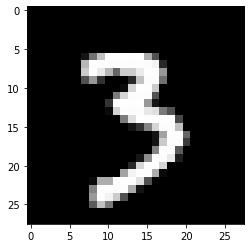

In [17]:
plt.imshow(x[0], cmap='gray')

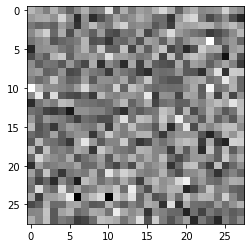

In [18]:
plt.imshow(out[0].detach(),cmap='gray')

In [19]:
def show_summary(valid_dl: DataLoader, model: nn.Module):
    ELEM_NUM = 15
    
    device = model.parameters().__next__().device
    ae.eval()

    actual_list = [x for i, (x, y) in enumerate(valid_dl.dataset) if i < ELEM_NUM]
    
    with torch.no_grad():
        actuals_batch = torch.cat(actual_list).unsqueeze(1)
        reconst_batch = ae(actuals_batch.to(device)).cpu().unsqueeze(1)
    
    ae.train()
    
    grid_elems = [*actuals_batch, *reconst_batch]

    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1, pad_value =1)
  
    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

In [20]:
def show_summary_1(valid_dl:DataLoader, model: nn.Module):
    ELEM_NUM = 15
    
    device = model.parameters().__next__().device
    
    ae.eval()
    
    actuals, reconst = [], []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            actuals.append(x)
            reconst.append(ae(x.to(device)).detach().cpu())
            if i == ELEM_NUM-1: break
    
    ae.train()
    
    grid_elems = [*actuals, *reconst]
    grid = tv.utils.make_grid(grid_elems, nrow=ELEM_NUM, padding=1,pad_value=1)

    plt.figure(figsize=(15,15))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

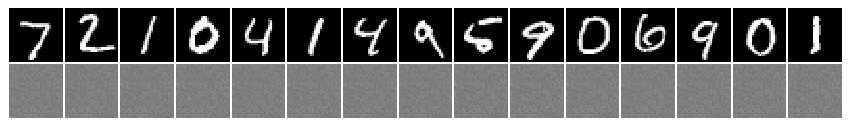

CPU times: user 1.15 s, sys: 2.36 ms, total: 1.15 s
Wall time: 1.13 s


In [21]:
%%time
show_summary(valid_dl,ae)

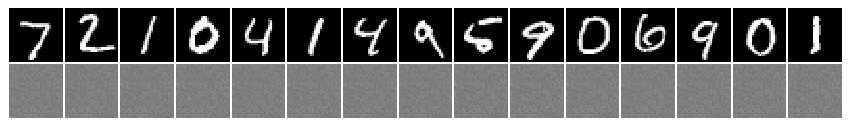

CPU times: user 206 ms, sys: 8.34 ms, total: 214 ms
Wall time: 173 ms


In [22]:
%%time
show_summary_1(valid_dl,ae)

In [23]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [24]:
seed_everything()

In [25]:
device = torch.device('cpu')
ae = ae.to(device)

In [30]:
def init_params(m:nn.Module):
    if type(m) == nn.Linear:
      nn.init.orthogonal_(m.weight.data)
      nn.init.zeros_(m.bias.data)
    

In [27]:
def train_autoencoder(train_dloader, valid_dloader, model:nn.Module, epochs=2, lr=0.001, summary_int=None):
    
    model.apply(init_params)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    
    LOG_INTERVAL = 200

    acc_cost = 0

    for epoch in range(0 ,epochs):
        for i, (x, y) in enumerate(train_dloader):
            optimizer.zero_grad()
            x = x.to(device)
            target = model(x).unsqueeze(1)
            cost = mse_loss(x, target)
            acc_cost += cost.item()
            cost.backward()
            optimizer.step()

            if (i%LOG_INTERVAL) == 0:
                print(f"epoch {epoch+1} | iter {i} | acc_cost {acc_cost/LOG_INTERVAL:.4f} | cost {cost:.4f}")
                acc_cost = 0       

            if  (summary_int is not None) and (i%summary_int)==0:
                show_summary_1(valid_dloader,model)

In [ ]:
train_autoencoder(train_dl, valid_dl, ae, epochs=5)

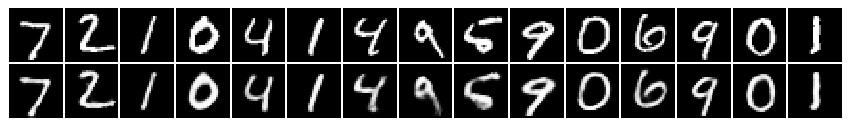

In [35]:
show_summary_1(valid_dl,ae)

In [36]:
print(ae)
for k, val in ae.state_dict().items():
    print(f'key: {k} val.shape: {val.shape}')
    
print('\n',ae.state_dict()['enc.enc.1.weight'])

AutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=784, out_features=512, bias=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=20, bias=True)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)
key: enc.enc.1.weight val.shape: torch.Size([512, 784])
key: enc.enc.1.bias val.shape: torch.Size([512])
key: enc.enc.3.weight val.shape: torch.Size([20, 512])
key: enc.enc.3.bias val.shape: torch.Size([20])
key: dec.dec.0.weight val.shape: torch.Size([512, 20])
key: dec.dec.0.bias val.shape: torch.Size([512])
key: dec.dec.2.weight val.shape: torch.Size([784, 512])
key: dec.dec.2.bias val.shape: torch.Size([784])

 tensor([[-0.0253, -0.0172, -0.0171,  ...,  0.0524,  0.0394,  0.0093],
        [ 0.0198,  0.0120,  0.0188,  ...,  0.0100,  0.0605,  0

In [37]:
#torch.save(ae.state_dict(),'ae_tained_weights.pt')

In [38]:
ae.load_state_dict(torch.load('ae_tained_weights.pt'))

<All keys matched successfully>

In [39]:
ae.eval()
z, labels = [], []
with torch.no_grad():
    for x, y in valid_dl:
        z.append(ae.enc(x))
        labels.append(y)
z = torch.cat(z)
labels = torch.cat(labels)

In [40]:
assert(z.shape == (10000,20))
assert(labels.shape == (10000,))

In [41]:
t_sne = TSNE(n_components=2)

In [42]:
q = t_sne.fit_transform(z)

In [43]:
df = pd.DataFrame({'x1':q[:,0], 'x2':q[:,1],'label':labels})

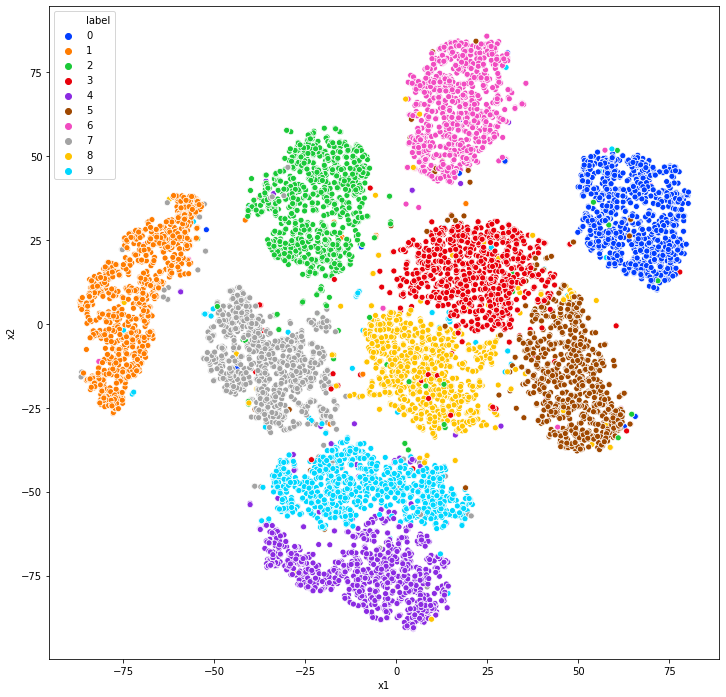

In [44]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='x1', y='x2', data=df, hue='label', legend='full',palette=sns.color_palette(palette='bright', n_colors=10))

0.08611347608460046
0.11511910966813468
0.09756594919187947
0.08452784219717108
0.10730562400453417
0.09501420863325329
0.1030990427345684
0.10270117648133999
0.10950657708749068
0.09904699391702561


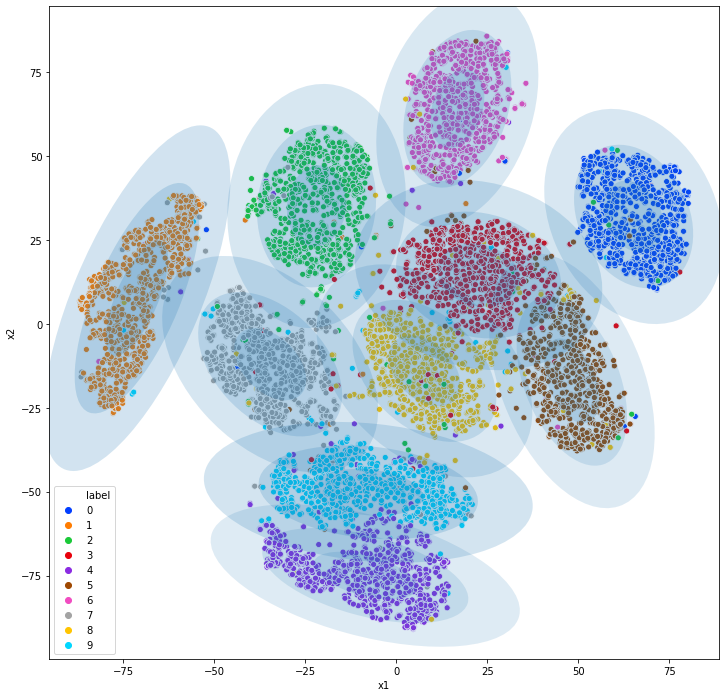

In [45]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        

def plot_gmm(gmm):
    
    plt.figure(figsize=(12, 12))
    ax = sns.scatterplot(x="x1", y="x2", hue="label", palette=sns.color_palette("bright", 10), data=df, legend="full")

    w_factor = 0.2/ gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        print(w)
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)

gmm = GMM(n_components=10, covariance_type='full', max_iter=300,n_init=5).fit(q) # number of components (number of clusters) equal to 10 digits we have
plot_gmm(gmm)

In [49]:
df['cluster'] = gmm.predict(q)

In [108]:
cluster_to_label = df.groupby('cluster').apply(lambda gr: gr.label.value_counts().idxmax()).to_dict()

In [109]:
cluster_to_label

{0: 5, 1: 1, 2: 6, 3: 4, 4: 3, 5: 8, 6: 7, 7: 2, 8: 9, 9: 0}

In [110]:
df['pred'] = df.cluster.map(cluster_to_label)

In [116]:
df.head(10)

,x1,x2,label,cluster,pred
0,-36.312195,-8.243155,7,6,7
1,-24.100649,26.319647,2,7,2
2,-66.029236,11.520390,1,1,1
3,69.328545,16.596270,0,9,0
4,1.027923,-86.800133,4,3,4
5,-69.537231,13.665672,1,1,1
6,-3.987732,-77.447433,4,3,4
7,10.812176,-43.200672,9,8,9
8,40.801907,-20.858484,5,0,5
9,-28.455906,-53.217861,9,8,9


In [114]:
per_cls_accuracy = df.groupby('label').apply(lambda gr: np.mean(gr.label==gr.pred))
per_cls_accuracy

label
0    0.990816
1    0.986784
2    0.959302
3    0.950495
4    0.837067
5    0.922646
6    0.985386
7    0.946498
8    0.906571
9    0.937562
dtype: float64

In [115]:
per_cls_accuracy.mean()

0.9423127852447936